In [6]:
import pandas as pd
import numpy as np
import pyemma as pm
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import pickle as p

## Introduction

This notebook makes a simple MSM from reaction coordinates identified by KR and defined in `exploratory/reaction_coordinates`. 

There are 13 bond distances which are reactive (e.g. H -- O, or would involved bond breaking) or stabilizing (hydrogen bonds). Inspection of the distribution of these revealed substantive differences between the two active sites. 

I'll start by investigating the `H` active site as that to appeared to have distinct clusters (by inspection of the free energy diagrams). 

## Data

In [7]:
df = pd.read_csv('../outputs/bond_distances.csv')
df.head()
df.sort_values(by=['Site','Trajectory', 't (ns)'], inplace=True)

In [8]:
dt = df['t (ns)'][1]-df['t (ns)'][0]
dt

0.01

In [9]:
df.columns

Index(['OD1-CI2', 'OD2-CI2', 'OD1-HI2', 'OD2-HI2', 'OD1-HI3', 'OD2-HI3',
       'HE1-OT', 'HE1-A82_O', 'HNT-OT', 'HNT-D84_O', 'OT-D84_H',
       'OD2-T172_HG1', 'OD1-W160_H', 't (ns)', 'Site', 'Trajectory'],
      dtype='object')

In [10]:
def split_df(df, cols, site='H'):
    X = []
    for k, v in df.loc[df['Site']==site, :].groupby('Trajectory'):
        X.append(v.loc[:, cols].values)
    return X

In [11]:
X = split_df(df, ['OD1-CI2', 'OD2-CI2', 'OD1-HI2', 'OD2-HI2', 'OD1-HI3', 'OD2-HI3',
       'HE1-OT', 'HE1-A82_O', 'HNT-OT', 'HNT-D84_O', 'OT-D84_H',
       'OD2-T172_HG1', 'OD1-W160_H'], site='D')

## Preprocess

This can take a long time.  Skip this if already run. 

TICA

In [7]:
tica = pm.coordinates.tica(X, lag=int(0.1/dt))
Y = tica.get_output()

Cluster

In [8]:
k = np.sqrt(X[0].shape[0]*len(X)).astype(int)
print(k)
cluster = pm.coordinates.cluster_mini_batch_kmeans(data=Y, k=1000, max_iter=1000)
dtrajs = cluster.dtrajs


1000


10-04-20 10:46:10 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[3] INFO     Cluster centers converged after 138 steps.


In [13]:
p.dump(file=open('reference_model/as_d_cluster.p', 'wb'), obj=cluster)

Compute its vs lags

In [14]:
lags = np.arange(1, 1000, 2).astype(int)
its_10 = pm.msm.its(dtrajs, lags = lags, nits=5)

In [26]:
p.dump(file=open('reference_model/as_d_its_10.p', 'wb'), obj={'lags': its_10.lags, 'timescales': its_10.timescales})

In [27]:
lags = np.arange(1000, 5000, 10).astype(int)
its_50 = pm.msm.its(dtrajs, lags = lags, nits=5)

In [28]:
p.dump(file=open('reference_model/as_d_its_50.p', 'wb'), obj={'lags': its_50.lags, 'timescales': its_50.timescales})

## Fit model
if previous code as run just start here. 


In [12]:
cluster = p.load(file=open('reference_model/as_d_cluster.p', 'rb'))
dtrajs = cluster.dtrajs

In [29]:
def plot(i, j, site='D', **kwargs):
    if(site=='H'):
        states = h_cols
    else:
        states = None
        
    X = df.loc[df['Site']==site, states].values
#     fig, ax = plt.subplots()
    fig, ax = pm.plots.plot_free_energy(X[:, i], X[:, j], cmap='viridis_r', **kwargs)
    ax.set_ylabel(states[j])
    ax.set_xlabel(states[i])
    return ax

In [13]:
# mm01 = pm.msm.estimate_markov_model(dtrajs, lag = int(0.1/dt))
mm = pm.msm.estimate_markov_model(dtrajs, lag = int(5/dt))

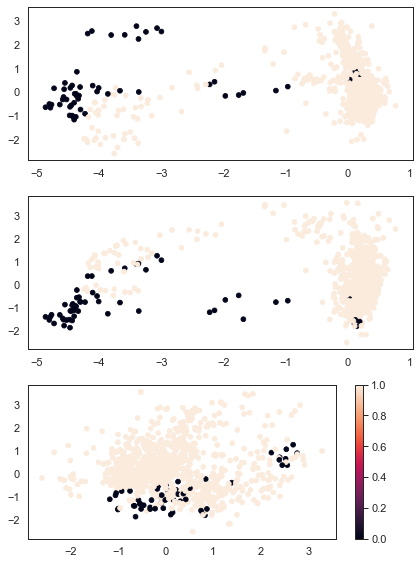

In [18]:
with sns.plotting_context('paper', font_scale=1.25):
    fig = plt.figure(figsize=(6,8))
    sns.set_style('white')
    m = mm
    for ix, (i, j) in enumerate([[0, 1], [0, 2], [1, 2]]):
        ax = fig.add_subplot(3,1, ix+1)
        if ix == 2:
            cbar=True
        else: 
            cbar=False
#         plot(i, j, 'H', )
#         pm.plots.plot_free_energy(np.concatenate(Y)[:, i], np.concatenate(Y)[:, j], cmap='viridis_r', 
#                                   **{'avoid_zero_count': True, 'levels': [0,1,2,3,4,5, 6,7, 8, 9, 10], 
#                            'ax': ax, 'cbar': cbar, 'alpha':0.5})
        
        c = ax.scatter(cluster.cluster_centers_[m.active_set, i], 
                       cluster.cluster_centers_[m.active_set, j], 
                       c=1*(m.eigenvectors_right()[:, 2]>0),
                      alpha=1)
        if ix==2:
            plt.colorbar(c)
        
    plt.tight_layout()